<font size="+3">Monitor : BindCraft Designs in Funnel Metadynamics  </font>


In [3]:
import pandas as pd
import numpy as np
import os
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import glob


from pandas.api.types import CategoricalDtype

In [4]:
def plot_adjust_settings(xlabel, ylabel, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_xlabel(xlabel,fontsize=11,labelpad=7)
    ax.set_ylabel(ylabel,fontsize=11,labelpad=7)
    ax.tick_params(labelsize=9, pad=5)
    

# Download

In [ ]:
%%bash
clst_dir=$( echo /scratch/nickel/260109_duo_design_CXCR4_funnel/ )
target_dir=$( echo /Users/roessner/Documents/PostDoc/Data/260109_duo_design_CXCR4_funnel )

#rsync -avz --include='reimage.*' --include='HILLS' --include='BIAS' --include='COLVAR' --include='*/' --exclude='*' nickel@172.19.48.4:$clst_dir $target_dir
rsync -avz --include='HILLS' --include='BIAS' --include='COLVAR' --include='*/' --exclude='*' nickel@kuma1.hpc.epfl.ch:$clst_dir $target_dir

rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at /AppleInternal/Library/BuildRoots/bc10cbcd-3cda-11ee-b8ac-16228a05f5d2/Library/Caches/com.apple.xbs/Sources/rsync/rsync/rsync.c(244) [receiver=2.6.9]


Process is interrupted.


# Free Energy Profile

In [1]:
%%bash
pwd=$(pwd)

declare -a params=( human mouse )

for batch in "${params[@]}"
do
    cd $batch
    for dir in */
    do
        binder=${dir%/}
        for i in {0..2}
        do
            dir="$pwd/$batch/$binder/$i"
            cd $dir
            plumed sum_hills --hills HILLS --outfile fes.dat 
            # every 10 ns
            rm -r FES
            mkdir FES
            plumed sum_hills --hills HILLS --outfile FES/fes. --stride 10000 --mintozero 
        done
    done
    cd $pwd
done

dyld[6911]: Library not loaded: '@rpath/liblapack.3.dylib'
  Referenced from: '/Users/roessner/miniconda3/envs/wheeler/lib/libplumedKernel.dylib'
  Reason: tried: '/Users/roessner/miniconda3/envs/wheeler/lib/liblapack.3.dylib' (no such file), '/Users/roessner/miniconda3/envs/wheeler/bin/../lib/liblapack.3.dylib' (no such file), '/Users/roessner/miniconda3/envs/wheeler/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)
bash: line 11:  6911 Abort trap: 6           plumed sum_hills --hills HILLS --outfile fes.dat
dyld[6918]: Library not loaded: '@rpath/liblapack.3.dylib'
  Referenced from: '/Users/roessner/miniconda3/envs/wheeler/lib/libplumedKernel.dylib'
  Reason: tried: '/Users/roessner/miniconda3/envs/wheeler/lib/liblapack.3.dylib' (no such file), '/Users/roessner/miniconda3/envs/wheeler/bin/../lib/liblapack.3.dylib' (no such file), '/Users/roessner/miniconda3/envs/wheeler/bin/../lib/liblapack.3.

Process is interrupted.


# Convergence

In [22]:
batches = ['human2mouse', 'mouse2human']
           
for i in batches:
    binders = [b for b in os.listdir(f'{i}') if os.path.isdir(f'{i}/{b}')]
    binders.sort()

    lst=[]
    for binder in binders:
        for j in range(3):
            ndir = f'{i}/{binder}/{j}/FES'
            files = [f for f in os.listdir(ndir) if os.path.isfile(os.path.join(ndir, f))]

            # rename and sort files
            for f in files:
                x = int(f.split(".")[1])
                dst = os.path.join(ndir, "fes.{0:04d}.dat".format(x))
                src = os.path.join(ndir, f) 
                os.rename(src, dst) 
                
            files = glob.glob(f'{ndir}/*.dat')
            files.sort()
            
            for f in files:
                df = pd.DataFrame()
                arr = np.loadtxt(f)               
                df["d"] = arr[:,0]
                df["fes"] = arr[:,1]
                df["step"] = f.split(".")[1]
                df["time"] = int(int(f.split(".")[1])*5) +5
                df['rep'] = j
                df['binder'] = binder
                lst.append(df)
        
    df = pd.concat(lst)
    df.to_pickle(f'fes-convergence-{i}.pkl')

Text(0.5, 0, 'Distance [nm]')

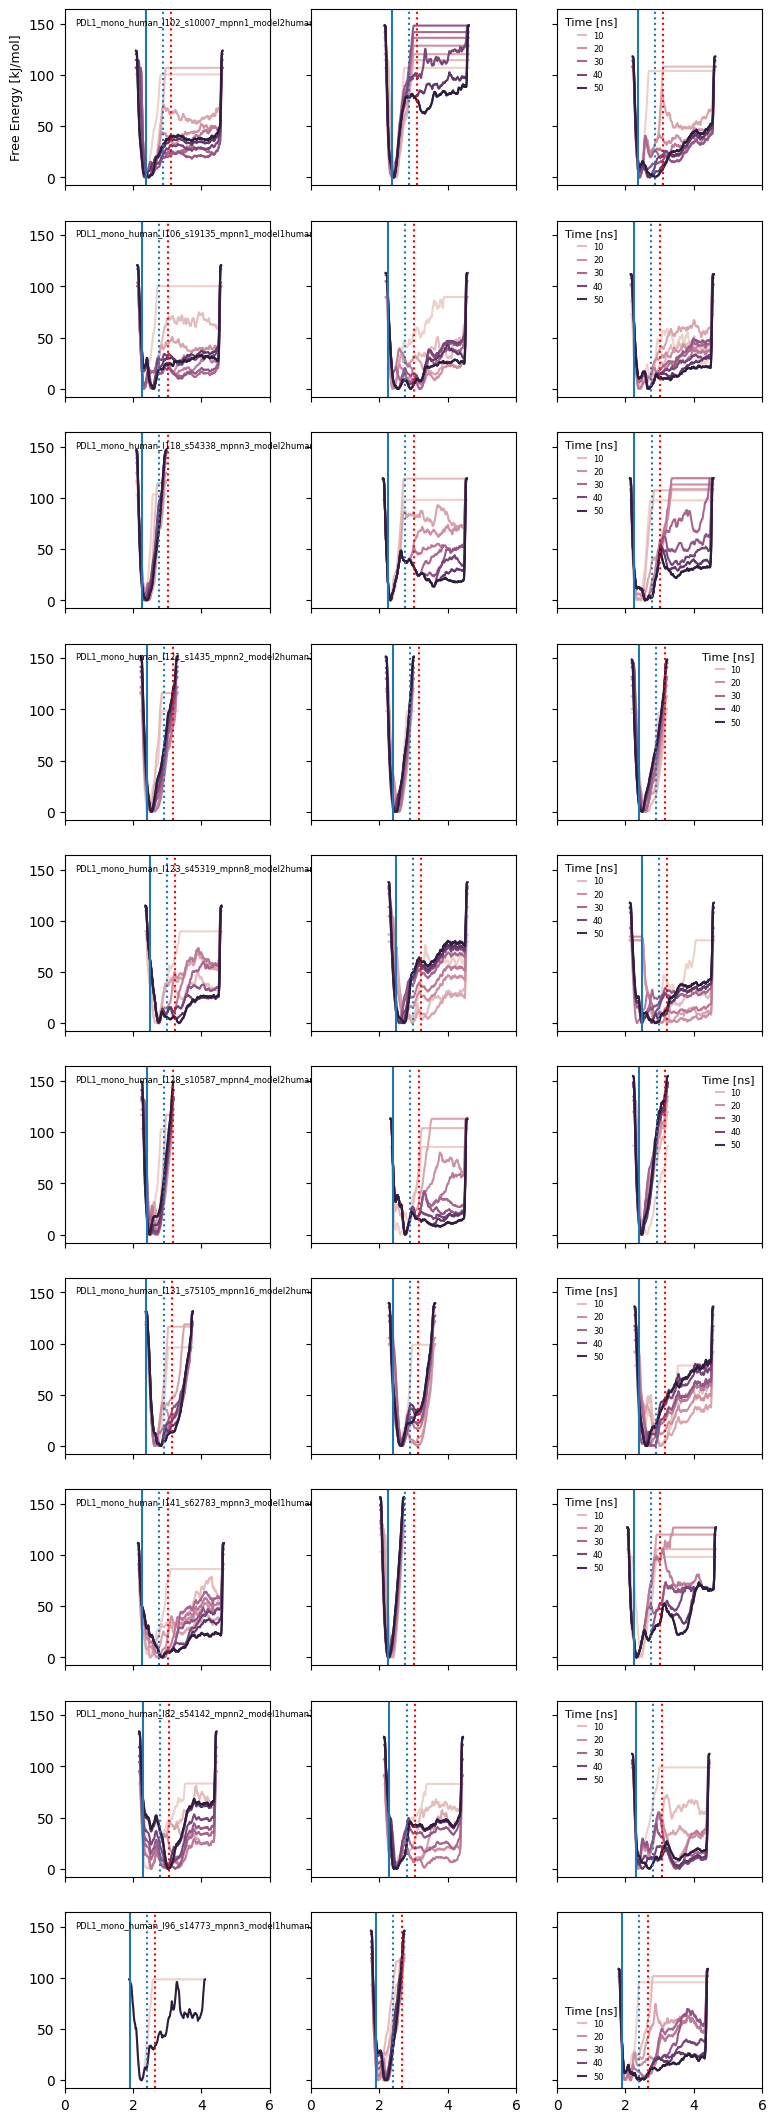

In [23]:
fig, axes = plt.subplots(10,3,figsize=(9,2.7*10), sharex=True, sharey=True)
batch = 'human2mouse'
df = pd.read_pickle(f'fes-convergence-{batch}.pkl')

for cnt, (name, group) in enumerate(df.groupby('binder')):
    for i in range(3):
        ax = axes[cnt][i]
        
        df_rep = group[group['rep'] == i]     
        sns.lineplot(df_rep, x='d', y='fes', hue='time', ax=ax)
        
        if i == 2:
            ax.legend(title='Time [ns]', title_fontsize=8, fontsize=6, frameon=False, handlelength=1)
        else:
            ax.legend([],[], frameon=False)

        ax.set_ylabel("")
        ax.set_xlabel("")
        
        # initial distance
        file = f'{batch}/{name}/{i}/COLVAR'
        if os.path.exists(file):
            df = pd.DataFrame()
            arr = np.loadtxt(file)
            dim = len(arr.shape)
            if dim == 1:
                pass
            else:
                init = arr[0,1]  
                ax.axvline(init)
                ax.axvline(init+0.5, linestyle=':', label='end bound')
                ax.axvline(init+0.75, linestyle=':', label='start unbound', color='red')
        ax.set_xlim(0,6)
        
    # Add text in the lower right
    axes[cnt][0].text(0.05, 0.95, name, transform=axes[cnt][0].transAxes, fontsize=6, ha='left', va='top')
    
axes[0][0].set_ylabel("Free Energy [kJ/mol]", fontsize=9)
axes[4][0].set_xlabel("Distance [nm]", fontsize=9)

# Binding Free Energy

In [24]:
def compute_FES(file, t_bound, t_unbound):
    # Constants
    kBT = 2.479  # in kJ/mol at 300 K
    V_ref = 1.661  # reference volume in nm^3 (1 mol/L)
    beta = 1 / kBT

    # Load FES: column 0 = fps.lp, column 1 = F (free energy)
    fes = np.loadtxt(file)
    z = fes[:, 0]
    F = fes[:, 1]

    # Bound region (adjust as needed)
    bound = (z > 0) & (z < t_bound)
    unbound = z > t_unbound

    # Integrate partition functions
    Z_bound = np.trapz(np.exp(-beta * F[bound]), z[bound])
    Z_unbound = np.trapz(np.exp(-beta * F[unbound]), z[unbound])

    # Binding free energy
    deltaG = -kBT * np.log(Z_bound / (Z_unbound * V_ref))
    #print(f"ΔG_bind = {deltaG:.2f} kJ/mol")
    return deltaG


In [28]:
batches = ['human', 'mouse', 'duo_human', 'duo_mouse', 'human2mouse', 'mouse2human']

def infer_target(batch: str) -> str:
    if '2mouse' in batch:   # check directional tags first
        return 'mouse'
    if '2human' in batch:
        return 'human'
    if 'mouse' in batch:    # then generic batch labels
        return 'mouse'
    if 'human' in batch:
        return 'human'
    return 'unknown'

dico = {'binder':[],
       'batch':[],
        'target':[],
       'rep':[],
       'deltaG':[]}

for i in batches:
    binders = [b for b in os.listdir(f'{i}') if os.path.isdir(f'{i}/{b}')]
    binders.sort()

    lst=[]
    for binder in binders:
        for j in range(3):
            ndir = f'{i}/{binder}/{j}/FES'
                
            files = glob.glob(f'{ndir}/*.dat')
            files.sort()

            if len(files) < 5:
                print(i, len(files))
            else:
                # initial distance
                colvar = f'{i}/{binder}/{j}/COLVAR'
                init = np.loadtxt(colvar)[0,1]
        
                deltaG = compute_FES(files[-1], t_bound=init+0.5, t_unbound=init+0.75)
                
                if deltaG == float('-inf'):
                    deltaG = -100
                elif deltaG < -100:
                    deltaG = -100
                else:
                    pass
          
                dico['binder'].append(binder)
                dico['batch'].append(i)
                dico['target'].append(infer_target(i))
                dico['rep'].append(j)
                dico['deltaG'].append(deltaG)
            
df = pd.DataFrame(dico)
df.to_pickle('deltaG.pkl')

mouse 0
mouse 0
mouse 0
human2mouse 2


In [38]:
# annotate
df = pd.read_pickle('deltaG.pkl')
df["Design"] = df["binder"].str.replace(r"_model\d+.*$", "", regex=True)
anno = pd.read_csv('experimental_labels.csv')
df_anno = pd.merge(df, anno, how='left', on='Design')
df_anno.to_pickle('deltaG_labled.pkl')
df_anno

,binder,batch,target,rep,deltaG,Design,Experimental
0,PDL1_mono_human_l102_s10007_mpnn1_model2human,human,human,0,-52.618186,PDL1_mono_human_l102_s10007_mpnn1,human
1,PDL1_mono_human_l102_s10007_mpnn1_model2human,human,human,1,-16.091608,PDL1_mono_human_l102_s10007_mpnn1,human
2,PDL1_mono_human_l102_s10007_mpnn1_model2human,human,human,2,-32.303153,PDL1_mono_human_l102_s10007_mpnn1,human
3,PDL1_mono_human_l106_s19135_mpnn1_model1human,human,human,0,-47.774389,PDL1_mono_human_l106_s19135_mpnn1,none
4,PDL1_mono_human_l106_s19135_mpnn1_model1human,human,human,1,-18.449690,PDL1_mono_human_l106_s19135_mpnn1,none
...,...,...,...,...,...,...,...
174,PDL1_mono_mouse_l86_s69910_mpnn14_model1mouse2...,mouse2human,human,1,-17.593202,PDL1_mono_mouse_l86_s69910_mpnn14,mouse
175,PDL1_mono_mouse_l86_s69910_mpnn14_model1mouse2...,mouse2human,human,2,-75.038174,PDL1_mono_mouse_l86_s69910_mpnn14,mouse
176,PDL1_mono_mouse_l97_s99849_mpnn4_model2mouse2h...,mouse2human,human,0,26.451066,PDL1_mono_mouse_l97_s99849_mpnn4,both
177,PDL1_mono_mouse_l97_s99849_mpnn4_model2mouse2h...,mouse2human,human,1,-38.758089,PDL1_mono_mouse_l97_s99849_mpnn4,both


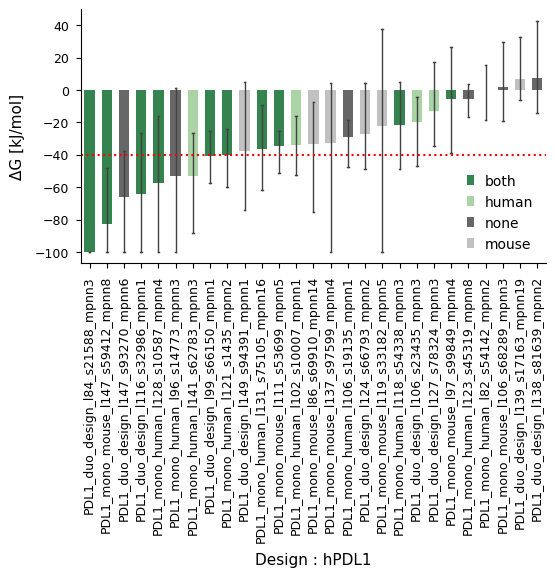

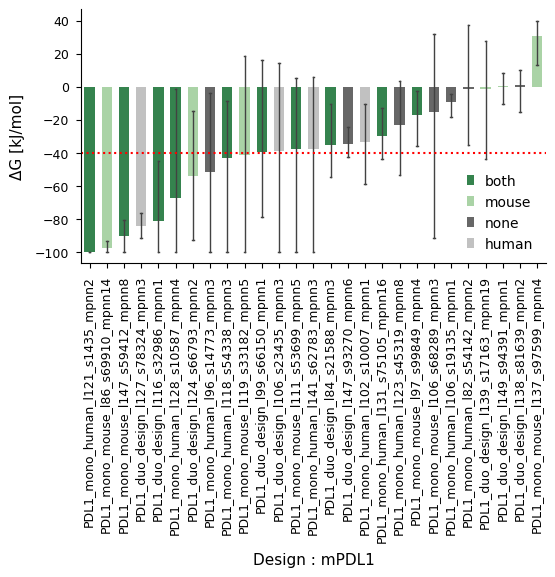

In [54]:
pal = ['#289049', '#a4da9e', '#676767', '#c1c1c1']
df_all = pd.read_pickle('deltaG_labled.pkl')
df_all = df_all[df_all['Experimental'] != 'unknown' ]

for name, df in df_all.groupby('target'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.3))
    
    if name == 'human':
        exp_order = CategoricalDtype(['both', 'human', 'none', 'mouse'], ordered=True)
    else:
        exp_order = CategoricalDtype(['both', 'mouse', 'none', 'human'], ordered=True)
    df['Experimental'] = df['Experimental'].astype(exp_order)

    df_avg = df.groupby(['Design', 'batch'], as_index=False)['deltaG'].mean()
    df_best = df_avg.groupby('Design')['deltaG'].min().sort_values()
    order = df_best.index.tolist()

    sns.barplot(df, x='Design', y='deltaG', hue='Experimental', ax=ax,
                errwidth=1, capsize=0.1, width=0.6, order=order, palette=pal)

    plot_adjust_settings(f'Design : {name[0]}PDL1', 'ΔG [kJ/mol]')
    ax.legend(frameon=False, title='', handlelength=0.5, loc='lower right')
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    ax.axhline(-40, color='red', linestyle=':')
    #ax.set_ylim(-130, 10)

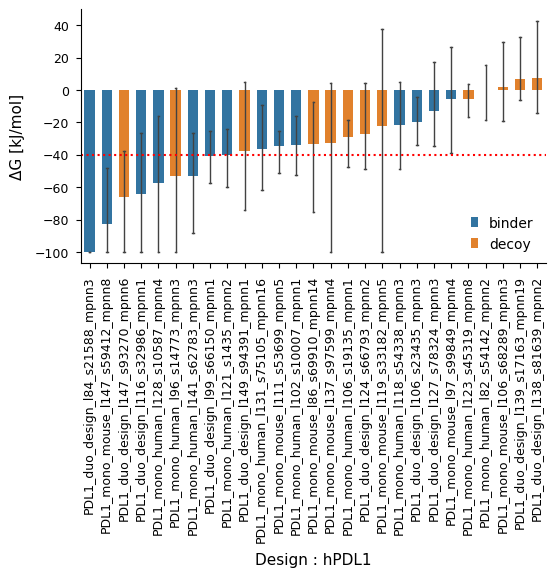

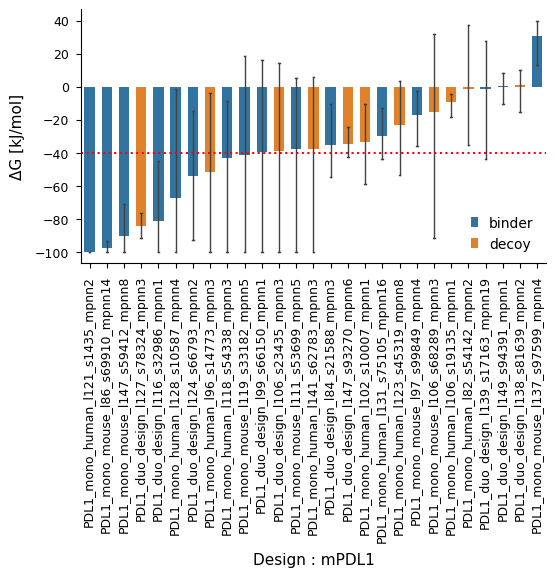

In [12]:
df_all = pd.read_pickle('deltaG_labled.pkl')
df_all = df_all[df_all['Experimental'] != 'unknown' ]

df_all['binary'] = np.select(
    [
        df_all['Experimental'].eq('none'),            # rule 1
        df_all['Experimental'].eq('both'),            # rule 2
        df_all['Experimental'].eq(df_all['target'])       # rule 3
    ],
    ['decoy', 'binder', 'binder'],
    default='decoy'
)


for name, df in df_all.groupby('target'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.3))
    
    df = df.sort_values(by = 'binary')
    df_avg = df.groupby(['Design', 'batch'], as_index=False)['deltaG'].mean()
    df_best = df_avg.groupby('Design')['deltaG'].min().sort_values()
    order = df_best.index.tolist()

    sns.barplot(df, x='Design', y='deltaG', hue='binary', ax=ax,
                errwidth=1, capsize=0.1, width=0.6, order=order)

    plot_adjust_settings(f'Design : {name[0]}PDL1', 'ΔG [kJ/mol]')
    ax.legend(frameon=False, title='', handlelength=0.5, loc='lower right')
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    ax.axhline(-40, color='red', linestyle=':')
    #ax.set_ylim(-130, 10)
    

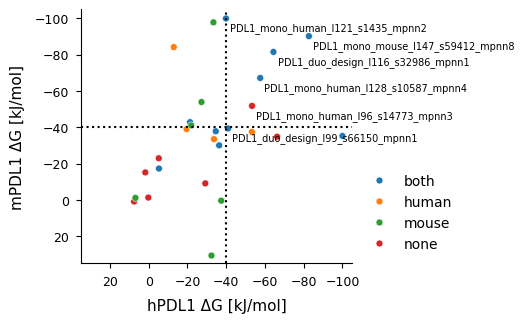

In [105]:
pal = ['#289049', '#a4da9e', '#676767', '#c1c1c1']
df = pd.read_pickle('deltaG_labled.pkl')
df = df_all[df_all['Experimental'] != 'unknown' ]

# per binder (averaged over replicas)
agg = (df.groupby(['Design', 'target', 'Experimental'])
         .agg(mean_deltaG=('deltaG','mean'),
              std_deltaG=('deltaG','std'))
         .reset_index())

lst=[]
for name, df in agg.groupby('target'):
    df = df.rename(columns={
        'mean_deltaG': f'{name}_mean_deltaG',
        'std_deltaG':  f'{name}_std_deltaG'
    })
    df = df.drop(columns=['target'])
    lst.append(df)

df = pd.merge(lst[0], lst[1], on=['Design', 'Experimental'])
exp_order = CategoricalDtype(['both', 'human', 'mouse', 'none'], ordered=True)
df['Experimental'] = df['Experimental'].astype(exp_order)
# plot
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.3))
sns.scatterplot(df, x='human_mean_deltaG', y='mouse_mean_deltaG', hue='Experimental', ax=ax, s=25)

plot_adjust_settings('hPDL1 ΔG [kJ/mol]', 'mPDL1 ΔG [kJ/mol]')
ax.legend(bbox_to_anchor=(1,0.4), frameon=False, loc='upper left')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlim(35, -105)
ax.set_ylim(35, -105)
sns.despine()
ax.axhline(-40, color='black', linestyle=':')
ax.axvline(-40, color='black', linestyle=':')

# labels
mask = (df['human_mean_deltaG'] < -39) & (df['mouse_mean_deltaG'] < -39)
for _, r in df[mask].iterrows():
    ax.annotate(r['Design'],
                (r['human_mean_deltaG'], r['mouse_mean_deltaG']),
                textcoords='offset points', xytext=(3, -3), ha='left', va='top',
                fontsize=7)

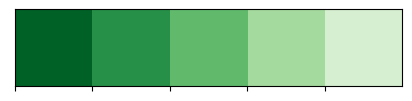

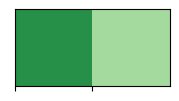

In [116]:
greens = sns.color_palette("Greens", n_colors=10)[::-2]  # or "BuGn", "YlGn" for variants
sns.palplot(greens)
binary = sns.color_palette([greens[1],greens[3]])
sns.palplot(binary)

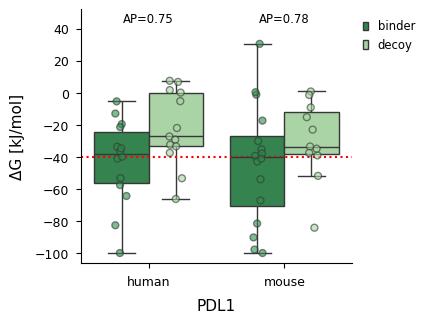

In [127]:
pal = ['#289049', '#a4da9e']
df = pd.read_pickle('deltaG_labled.pkl')
df = df[df['Experimental'] != 'unknown' ]

# per binder (averaged over replicas)
df = (df.groupby(['Design', 'target', 'Experimental'])
         .agg(deltaG=('deltaG','mean'))
         .reset_index())

df['binary'] = np.select(
    [
        df['Experimental'].eq('none'),            # rule 1
        df['Experimental'].eq('both'),            # rule 2
        df['Experimental'].eq(df['target'])       # rule 3
    ],
    ['decoy', 'binder', 'binder'],
    default='decoy'
)

# plot
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.3))
sns.boxplot(df, x='target', y='deltaG', hue='binary', ax=ax, showfliers=False, palette=binary)
sns.stripplot(df, x='target', y='deltaG', hue='binary', dodge=True,
              jitter=True, alpha=0.6, marker='o', linewidth=1, palette=binary)

plot_adjust_settings('PDL1', 'ΔG [kJ/mol]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:2], labels=labels[:2], frameon=False, title='', handlelength=0.5, fontsize='small', loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(-40, color='red', linestyle=':')
sns.despine()

# average precision
from sklearn.metrics import average_precision_score

# compute AP per target (binder=positive), lower ΔG -> higher score
ap_by_target = (df.assign(y=(df['binary'] == 'binder').astype(int),
                          score=-df['deltaG'])
                  .groupby('target')
                  .apply(lambda g: average_precision_score(g['y'], g['score']))
                  .to_dict())

# after plotting:
ymax = ax.get_ylim()[1]
ax.set_ylim(ax.get_ylim()[0], ymax + 15)  # headroom
for x, lbl in zip(ax.get_xticks(), [t.get_text() for t in ax.get_xticklabels()]):
    if lbl in ap_by_target:
        ax.text(x, ymax + 5, f"AP={ap_by_target[lbl]:.2f}",
                ha='center', va='bottom', fontsize='small')

0.5925925925925926


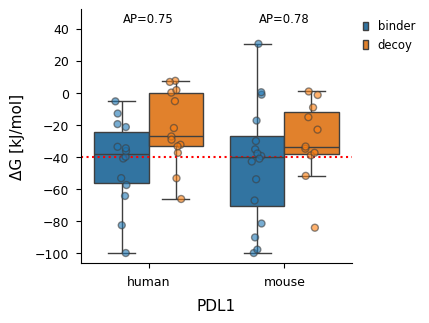

In [17]:
pal = ['#289049', '#a4da9e']
df = pd.read_pickle('deltaG_labled.pkl')
df = df[df['Experimental'] != 'unknown' ]

# per binder (averaged over replicas)
df = (df.groupby(['Design', 'target', 'Experimental'])
         .agg(deltaG=('deltaG','mean'))
         .reset_index())

df['binary'] = np.select(
    [
        df['Experimental'].eq('none'),            # rule 1
        df['Experimental'].eq('both'),            # rule 2
        df['Experimental'].eq(df['target'])       # rule 3
    ],
    ['decoy', 'binder', 'binder'],
    default='decoy'
)

tmp = df[df['target'] == 'mouse']
binders = tmp[tmp['binary'] == 'binder']
print(len(binders)/len(tmp))

# plot
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.3))
sns.boxplot(df, x='target', y='deltaG', hue='binary', ax=ax, showfliers=False)
sns.stripplot(df, x='target', y='deltaG', hue='binary', dodge=True,
              jitter=True, alpha=0.6, marker='o', linewidth=1)

plot_adjust_settings('PDL1', 'ΔG [kJ/mol]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:2], labels=labels[:2], frameon=False, title='', handlelength=0.5, fontsize='small', loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(-40, color='red', linestyle=':')
sns.despine()

# average precision
from sklearn.metrics import average_precision_score

# compute AP per target (binder=positive), lower ΔG -> higher score
ap_by_target = (df.assign(y=(df['binary'] == 'binder').astype(int),
                          score=-df['deltaG'])
                  .groupby('target')
                  .apply(lambda g: average_precision_score(g['y'], g['score']))
                  .to_dict())

# after plotting:
ymax = ax.get_ylim()[1]
ax.set_ylim(ax.get_ylim()[0], ymax + 15)  # headroom
for x, lbl in zip(ax.get_xticks(), [t.get_text() for t in ax.get_xticklabels()]):
    if lbl in ap_by_target:
        ax.text(x, ymax + 5, f"AP={ap_by_target[lbl]:.2f}",
                ha='center', va='bottom', fontsize='small')